In [1]:
# installs the covid19_inference library
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git@v0.1.8

  Cloning https://github.com/Priesemann-Group/covid19_inference.git (to revision v0.1.8) to /tmp/pip-req-build-55t8hpys
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-55t8hpys
  Running command git checkout -b v0.1.8 --track origin/v0.1.8
  Switched to a new branch 'v0.1.8'
  Branch 'v0.1.8' set up to track remote branch 'v0.1.8' from 'origin'.
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=102471 sha256=207630393f6bfaade979cf092077fd3ed1176c9a1e8d4e8b7fa485ec71dd92c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-geo1q2lg/wheels/42/e7/e7/ee2035dd9edc0646359231afc5b2af9bf89c40c8256e0d6dba
Successfully built covid19-inference


In [2]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
import covid19_inference as cov19

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Using the covid19_inference to download data from John Hopkins University (JHU) 
jhu = cov19.data_retrieval.JHU()
jhu.download_all_available_data()

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


In [4]:
# getting the Kenyan confirmed, recovered, deaths numbers from JHU data
dfKe = jhu.get_total_confirmed_deaths_recovered(country="Kenya")

# get the rows where the number of cases is more than a 100
dfKe100 = dfKe.loc[dfKe['confirmed'] >= 100]
dfKe100.tail(10)

,confirmed,deaths,recovered
date,,,
2020-07-31,20636,341,8165
2020-08-01,21363,364,8419
2020-08-02,22053,369,8477
2020-08-03,22597,382,8740
2020-08-04,23202,388,9327
2020-08-05,23873,391,9930
2020-08-06,24411,399,10444
2020-08-07,25138,413,11118
2020-08-08,25837,418,11899


In [5]:
# Check if the date column has null values
dfKe100.reset_index()['date'].isna().sum()

0

In [6]:
bd = datetime.datetime(2020, 4, 2)  # For the date filter (The first day with more than a 100 confirmed cases)
ed = datetime.datetime.now()

# geting the number of new cases for each day
new_cases_obs = jhu.get_new(
    value="confirmed", country="Kenya", data_begin=bd, data_end=ed
)

In [7]:
from sklearn.model_selection import train_test_split
X = new_cases_obs
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

In [8]:
# Creating the priors for change points and other configuration

diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 25

# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 4, 6)
prior_date_strong_dist_begin = datetime.datetime(2020, 5, 7)
prior_date_contact_ban_begin = datetime.datetime(2020, 7, 6)

change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]

In [9]:
"""
    Next, we create the model! There are default values for most of the function arguments,
    but we will try to explicitly set all kwargs for the sake of this example.
"""
params_model = dict(
    new_cases_obs=X_train[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)

# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

"""
    The model is specified in a context. Each function in this context
    has access to the model parameters set.
"""
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)


INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  

In [10]:
"""## MCMC sampling

    After the model is built, it is sampled using an MCMC sampler.
    The number of parallel runs can be set with the argument `cores=`.
    In particular, due to a bug in Theano, Windows users should set `cores=1`.
    The sampling can take a long time.
"""

trace = pm.sample(model=this_model, tune=500, draws=1000, init="advi+adapt_diag")

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 678.9:  19%|█▉        | 37691/200000 [05:55<25:32, 105.93it/s]
Convergence achieved at 37700
INFO     [pymc3.variational.inference] Convergence achieved at 37700
Interrupted at 37,699 [18%]: Average Loss = 702.87
INFO     [pymc3.variational.inference] Interrupted at 37,699 [18%]: Average Loss = 702.87
Sequential sampling (2 chains in 1 job)
INFO     [pymc3] Sequential sampling (2 chains in 1 job)
NUTS: [sigma_obs, offset_modulation_rad, we

['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_log_', 'transient_len_2_log_', 'transient_len_3_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


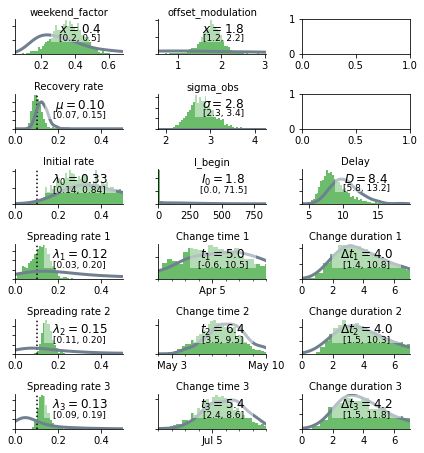

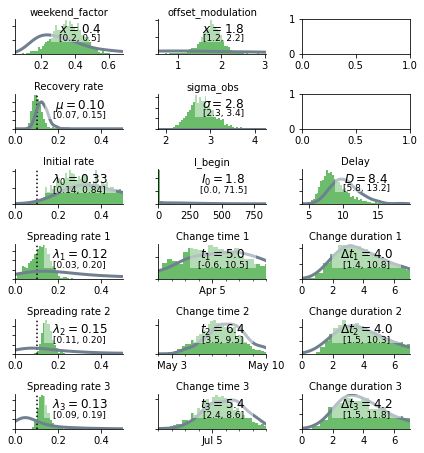

In [11]:
"""## Plotting
    Plotting tools are rudimentary right now. But one can always write custom plotting function
    by accessing the samples stored in the trace.

    ### Distributions
"""
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))

# Get the free Random Variables
varnames = this_model.untransformed_freeRVs
print(varnames)

# Plot them
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])

for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])

fig.tight_layout()
fig

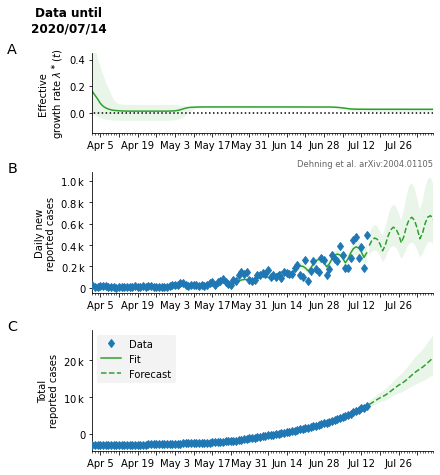

In [12]:
"""### Timeseries
    timeseries overview, for now needs an offset variable to get cumulative cases
"""
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=-3000)

In [13]:
# Getting the forecast values from the model
fcast_x, fcast_y = cov19.plot._get_array_from_trace_via_date(this_model, trace, 'new_cases', this_model.fcast_begin, this_model.fcast_end )

In [14]:
# Evaluating the models performance i.e how accurate is the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mean_squared_error(X_test.head(25), fcast_x[0])**0.5

216.36890628952253

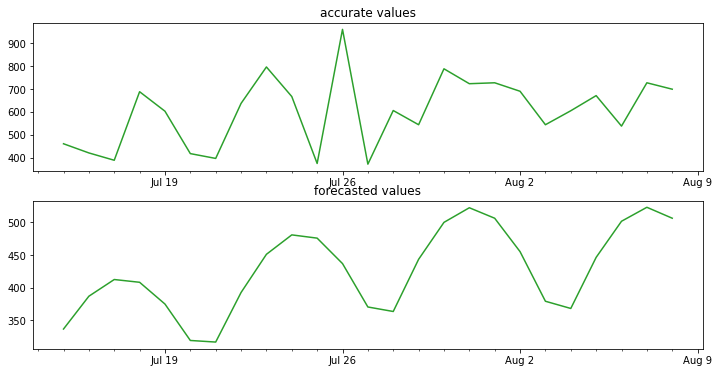

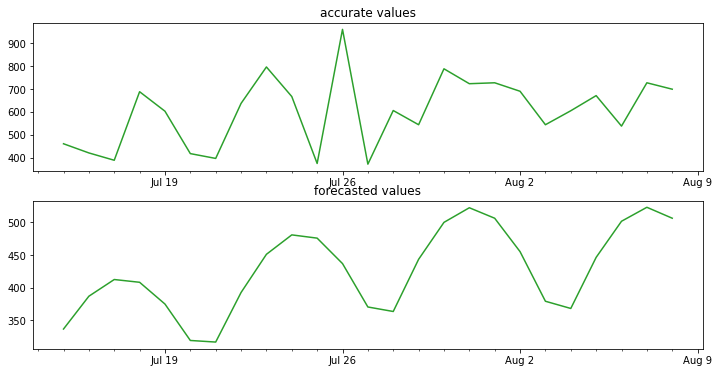

In [15]:
# Create a multiplot
fig1, axes1 = plt.subplots(2,1, figsize=(12,6))

# Visual representation of the models performance
cov19.plot._timeseries(x=X_test.head(25).index, y=X_test.head(25), ax=axes1[0], what='model')
cov19.plot._timeseries(x=fcast_y, y=fcast_x[0],ax=axes1[1], what='model')

# Label the plots

axes1[0].set_title("accurate values")

axes1[1].set_title("forecasted values")

# Show the figure
fig1.show()
fig1

# Reruning the model above with the whole dataset and predict until 10th August (Exact same code as above only changes are the days predicted and the data)

In [16]:
# Creating the priors for change points and other configuration

diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 5 # prediction days

# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 4, 6)
prior_date_strong_dist_begin = datetime.datetime(2020, 5, 7)
prior_date_contact_ban_begin = datetime.datetime(2020, 7, 6)

change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]


In [17]:
"""
    Next, we create the model! There are default values for most of the function arguments,
    but we will try to explicitly set all kwargs for the sake of this example.
"""
params_model = dict(
    new_cases_obs=X[:], # Data Change
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)

# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

"""
    The model is specified in a context. Each function in this context
    has access to the model parameters set.
"""
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)


INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  

In [18]:
"""## MCMC sampling

    After the model is built, it is sampled using an MCMC sampler.
    The number of parallel runs can be set with the argument `cores=`.
    In particular, due to a bug in Theano, Windows users should set `cores=1`.
    The sampling can take a long time.
"""

trace = pm.sample(model=this_model, tune=500, draws=1000, init="advi+adapt_diag")

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 936.12:  22%|██▏       | 43096/200000 [07:13<26:17, 99.48it/s] 
Convergence achieved at 43100
INFO     [pymc3.variational.inference] Convergence achieved at 43100
Interrupted at 43,099 [21%]: Average Loss = 966.55
INFO     [pymc3.variational.inference] Interrupted at 43,099 [21%]: Average Loss = 966.55
Sequential sampling (2 chains in 1 job)
INFO     [pymc3] Sequential sampling (2 chains in 1 job)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_3, transient_day_2, transient_day_1, lambda_3_log_, lambda_2_log_, lambda_1_log_, lambda_0_log_]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_lo

['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_log_', 'transient_len_2_log_', 'transient_len_3_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


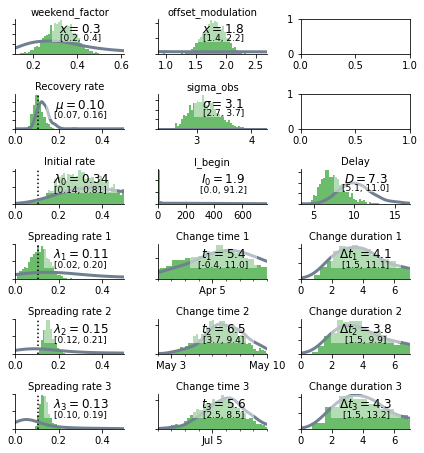

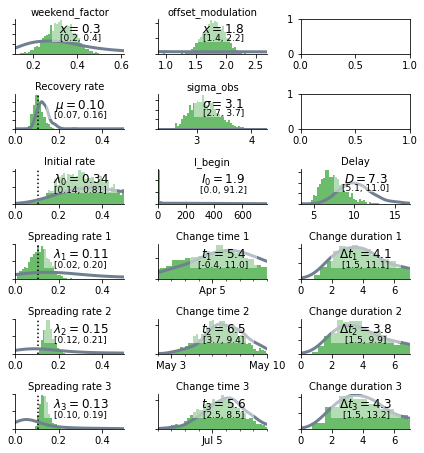

In [19]:
"""## Plotting
    Plotting tools are rudimentary right now. But one can always write custom plotting function
    by accessing the samples stored in the trace.

    ### Distributions
"""
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))

# Get the free Random Variables
varnames = this_model.untransformed_freeRVs
print(varnames)

# Plot them
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])

for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])

fig.tight_layout()
fig

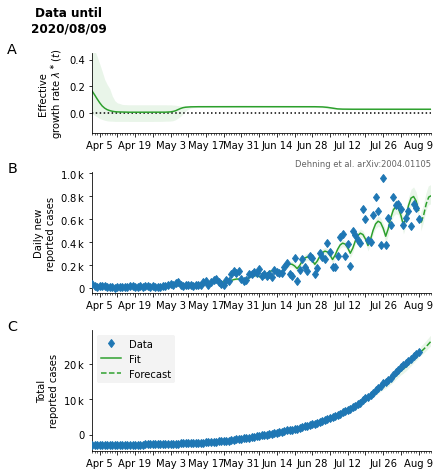

In [20]:
"""### Timeseries
    timeseries overview, for now needs an offset variable to get cumulative cases
"""
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=-3000)